# Bitcoin Price Prediction using Deep Learning Techniques

This notebook holds all experiments for the paper [insert name here](insert-link-here)

---

### Authors
 - Author1
 - Author2
 - Author3
    
### Date Created: 2024-04-22
### Date Last Modified: 2024-04-22

In [1]:
!nvidia-smi

Tue Apr 23 21:13:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P0              N/A /  60W |      8MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# We intend to shut down all warnings, and non-essential information in this notebook from TensorFlow
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler

from typing import List, Tuple, Dict

In [4]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [5]:
# Checking the version of TensorFlow
print(tf.__version__)

2.15.0


## Dataset Preparation

In [6]:
dataframe = pd.read_csv('data/BTC-USD.csv', parse_dates=['Date'], index_col='Date')
dataframe.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [7]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3505 entries, 2014-09-17 to 2024-04-21
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3505 non-null   float64
 1   High       3505 non-null   float64
 2   Low        3505 non-null   float64
 3   Close      3505 non-null   float64
 4   Adj Close  3505 non-null   float64
 5   Volume     3505 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 191.7 KB


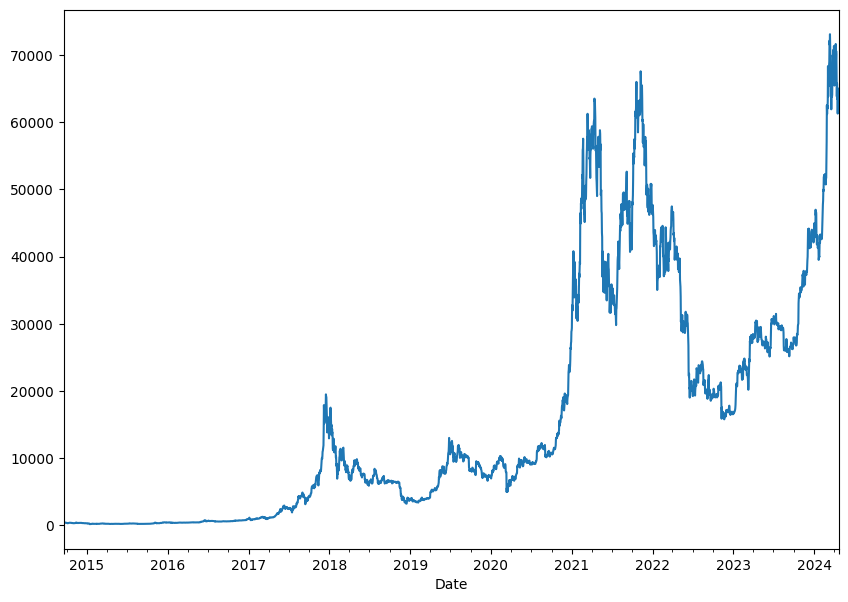

In [8]:
dataframe['Close'].plot(figsize=(10, 7));

In [10]:
# `btcc_prices` denotes the closing prices of BTC-USD.
btcc_prices = pd.DataFrame(dataframe["Close"].values, columns=["Price"], index=dataframe.index)
btcc_prices.head()

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


In [11]:
prices = btcc_prices['Price'].to_numpy()
prices

array([  457.334015,   424.440002,   394.79599 , ..., 63843.570313,
       64994.441406, 64773.386719])

In [12]:
# Normalizing the data
scaler = MinMaxScaler()

prices_normal = scaler.fit_transform(prices.reshape(-1, 1))
prices_normal

array([[0.00383005],
       [0.00337886],
       [0.00297225],
       ...,
       [0.87326138],
       [0.88904719],
       [0.88601512]])

In [13]:
# Create a plotting function
def plot_time_series(timestamps: List, values: List, format="-", start=0, end=None, title=None,
                     yLabel='BTC USD Close') -> None:
    """
    Plots a series of timestamps against values.

    Parameters
    ----------
    timestamps : list
        list of timestamp values
    values : list
        list of values across time
    format : str
        style of plot, default "."
    start : int
        starting index of the plot, ``start < len(timestamps)``
    end : int
        ending index of the plot, ``end < len(timestamps)``
    title : str
        label to show on plot of values
    """

    plt.plot(timestamps[start:end], values[start:end], format, label=title)
    plt.xlabel('Time')
    plt.ylabel(yLabel)
    if title:
        plt.legend(fontsize=14)
    plt.grid(True)


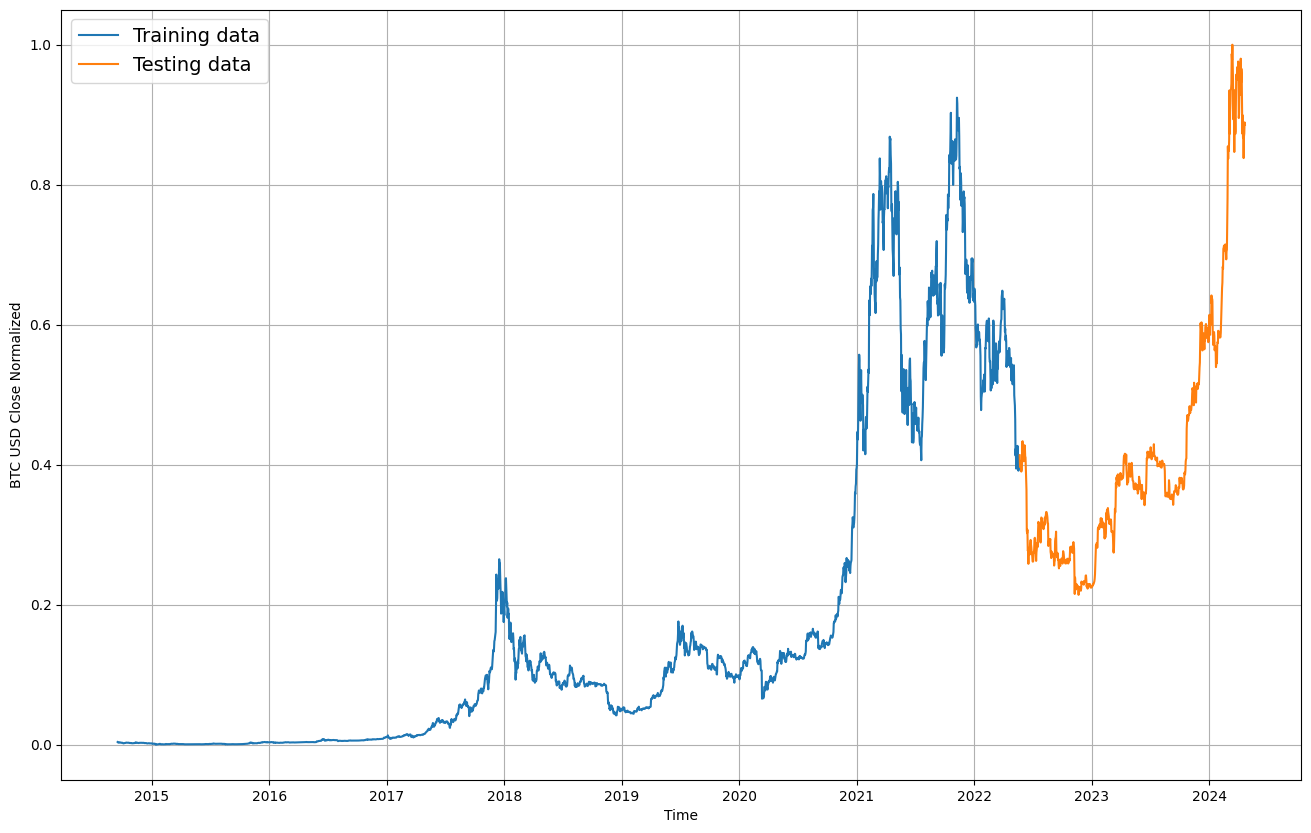

In [14]:
timestamps = btcc_prices.index.to_numpy()
training_data_len = int(.8 * len(btcc_prices))
test_data_len = len(btcc_prices) - training_data_len

plt.figure(figsize=(16, 10))
plot_time_series(timestamps=timestamps[:training_data_len], values=prices_normal[:training_data_len],
                 title="Training data")
plot_time_series(timestamps=timestamps[-test_data_len:], values=prices_normal[-test_data_len:], title="Testing data",
                 yLabel='BTC USD Close Normalized')

## Evaluation Metrics

In [15]:
def evaluate_pred(y_true: List, y_pred: List) -> Dict:
    """
    Performs various evaluation comparison functions on y_true labels and y_pred labels.

    Parameters
    ----------
    y_true : List
        true values
    y_pred : List
        predicted values

    Returns
    -------
    errors : dict
        dictionary containing the evaluation metrics, each metric is defined as a key-value pair where the key is the acronym for the metric in lowercase English.
    """
    # Make sure float32 datatype (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various evaluation metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)

    if mae.ndim > 0:
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)

    metric_results = {
        "mae": mae.numpy(),
        "mse": mse.numpy(),
        "rmse": rmse.numpy(),
        "mape": mape.numpy(),
    }
    return metric_results

## Create Windows

In [16]:
WINDOW_SIZE = 7
HORIZON = 1

In [17]:
def get_labelled_windows(x: List, horizon=HORIZON) -> Tuple:
    """
    Creates labels for windowed dataset.

    E.g. if horizon=1 (default)
    Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
    """
    return x[:, :-horizon], x[:, -horizon:]

In [18]:
def make_windows(x: List, window_size=WINDOW_SIZE, horizon=HORIZON):
    """
    Turns a 1D array of sequential data into a 2D array of windowed data.

    E.g.
    x before windowing: [1, 2, 3, 4, 5, 6, 7, 8] size = (8),
    x after windowing: [[1, 2, 3, 4, 5], [2, 3, 4, 5, 6], [3, 4, 5, 6, 7]] size = (3, 5)
    """

    window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)
    window_indices = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)), axis=0).T
    windowed_array = x[window_indices]
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
    return tf.squeeze(windows), tf.squeeze(labels)

In [19]:
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of windows and labels into train and test splits.

    E.g. if len(windows) = 100, len(labels) = 100 and test_split = 0.2
    80 windows and labels will go to the training set and 20 will go to the test set.
    """
    split_size = int(len(windows) * (1 - test_split))
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

## Prepare Utilities for Training

In [20]:
# Create a Checkpoint & EarlyStopping callback

def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(save_path, model_name),
        verbose=0,
        save_best_only=True,
    )


def create_early_stopping(patience=3):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=patience,
        restore_best_weights=True,
        verbose=1,
    )

## Model Experiments

1. FNN (Feed-forward, Densely Connected Network)
2. LSTM (Long Short-Term Memory)
3. Bi-LSTM (Bidirectional Long Short-Term Memory)
4. GRU (Gated Recurrent Unit)
5. Bi-GRU (Bidirectional Gated Recurrent Unit)
6. Conv1D (1-Dimensional Convolutional Neural Network)
7. N-BEATS (Neural Basis Expansion Analysis Time Series Model)

Each model will be trained and validated on the following window sizes and horizons:
- Window Size: 7, Horizon: 1
- Window Size: 7, Horizon: 7
- Window Size: 30, Horizon: 1
- Window Size: 30, Horizon: 7
- Window Size: 90, Horizon: 1
- Window Size: 90, Horizon: 7
- Window Size: 90, Horizon: 30

In [ ]:
all_res = {}

In [21]:
def fit_eval(
        model: tf.keras.models.Model,
        horizon=HORIZON,
        window=WINDOW_SIZE,
        epochs=100,
        fit_verbose=0,
) -> Tuple[List, Dict]:
    """
    Creates sliding windows for the given `WINDOW_SIZE` and `HORIZON`.
    Compiles and fits the model on the data for given number of `epochs`.
    Returns a dictionary of evaluation metrics.

    :param model: tf.keras.models.Model: the model to compile and fit
    :param horizon: int: the number of steps into the future to predict
    :param window: int: the number of timestamps to include in the input window
    :param epochs: int
    :param fit_verbose: int: level of verbosity of the fit method
    :return: a tuple containing the de-normalized predictions and a dictionary of evaluation metrics
    """

    # Clone the model to ensure a fresh copy is used
    model_clone = tf.keras.models.clone_model(model)
    train_windows, test_windows, train_labels, test_labels = make_train_test_splits(
        *make_windows(
            prices_normal,
            window_size=window,
            horizon=horizon,
        ))

    model_clone.build(input_shape=(None, window))

    model_clone.add(tf.keras.layers.Dense(horizon, activation="linear"))

    model_clone.compile(loss="mae",
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["mae", "mse", "mape"])

    history = model_clone.fit(
        train_windows,
        train_labels,
        epochs=epochs,
        batch_size=128,
        validation_data=(test_windows, test_labels),
        callbacks=[
            create_model_checkpoint(model_name=model_clone.name + "W" + str(window) + "H" + str(horizon)),
            create_early_stopping(patience=8)
        ],
        verbose=fit_verbose,
    )

    pd.DataFrame({"Validation MAPE": history.history['val_mape']}).plot(title="Validation MAPE", figsize=(8, 6))

    print("\n" + "-" * 20 + "\nEvaluating model on test data...")
    print(model_clone.evaluate(test_windows, test_labels, verbose=0))

    model_preds = model_clone.predict(test_windows)
    test_labels_inv = scaler.inverse_transform(tf.reshape(test_labels, shape=(-1, 1)))
    model_preds_inv = scaler.inverse_transform(tf.reshape(model_preds, shape=(-1, 1)))
    model_res = evaluate_pred(y_true=test_labels_inv, y_pred=model_preds_inv)

    return model_preds_inv, model_res


In [22]:
def save_model_plot(model: tf.keras.Model):
    """
    Saves the TF Model and a plot of the model to the filesystem.
    :param model:
    :return:
    """
    tf.keras.saving.save_model(model, os.path.join("model_experiments", model.name))
    tf.keras.utils.plot_model(
        model,
        show_shapes=True,
        show_layer_activations=True,
        to_file=os.path.join("model_experiments", model.name + ".png")
    )
    print(f"Model saved to: {os.path.join('model_experiments', model.name, '')}")
    print(f"Model plot saved to: {os.path.join('model_experiments', model.name + '.png')}")

### FNN (Feed-forward, Densely Connected Network)

In [23]:
model_fnn = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
], name="FNN")

#### FNN - Window Size 7, Horizon 1

I0000 00:00:1713887068.863369    7964 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Restoring model weights from the end of the best epoch: 25.
Epoch 33: early stopping

--------------------
Evaluating model on test data...
[0.009144512005150318, 0.009144512005150318, 0.00021747643768321723, 2.1543400287628174]
22/22 [==============================] - 0s 687us/step


{'mae': 666.6842, 'mse': 1155930.2, 'rmse': 666.6842, 'mape': 2.1398752}

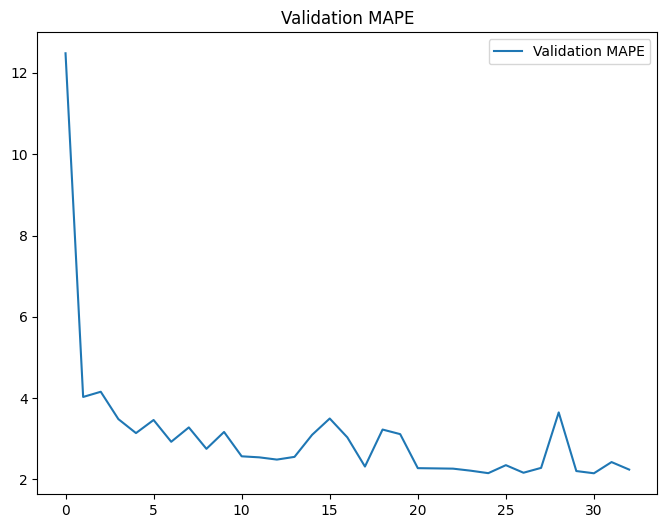

In [24]:
model_fnn_w7h1_preds_inv, model_fnn_w7h1_res = fit_eval(model_fnn, horizon=1, window=7)
model_fnn_w7h1_res

#### FNN - Window Size 7, Horizon 7

Restoring model weights from the end of the best epoch: 27.
Epoch 35: early stopping

--------------------
Evaluating model on test data...
[0.017339851707220078, 0.017339851707220078, 0.0007637561648152769, 4.127341270446777]
22/22 [==============================] - 0s 640us/step


{'mae': 1264.1686, 'mse': 4059514.8, 'rmse': 1264.1686, 'mape': 4.0994177}

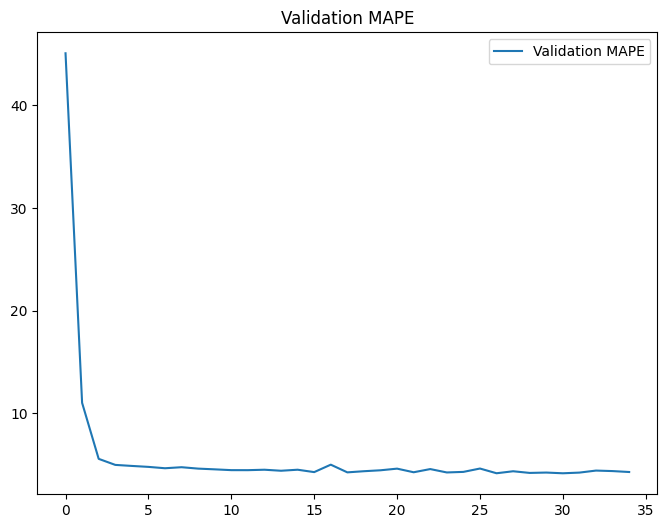

In [25]:
model_fnn_w7h7_preds_inv, model_fnn_w7h7_res = fit_eval(model_fnn, horizon=7, window=7)
model_fnn_w7h7_res

#### FNN - Window Size 30, Horizon 1

Restoring model weights from the end of the best epoch: 40.
Epoch 48: early stopping

--------------------
Evaluating model on test data...
[0.00983686838299036, 0.00983686838299036, 0.00023083429550752044, 2.379861831665039]
22/22 [==============================] - 0s 645us/step


{'mae': 717.16077, 'mse': 1226929.8, 'rmse': 717.16077, 'mape': 2.363645}

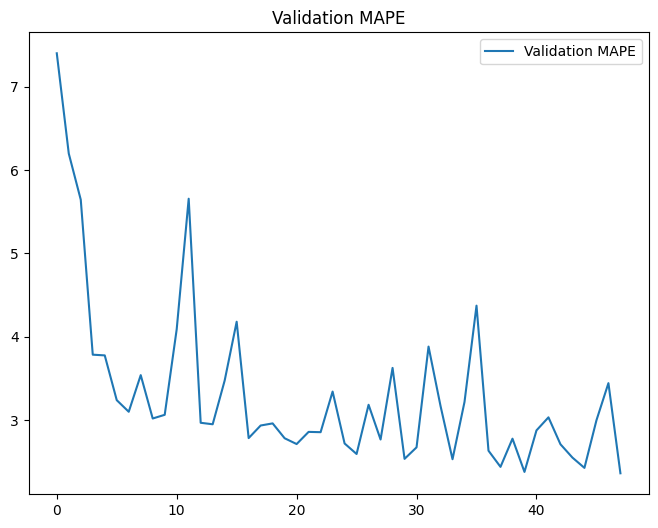

In [26]:
model_fnn_w30h1_preds_inv, model_fnn_w30h1_res = fit_eval(model_fnn, horizon=1, window=30)
model_fnn_w30h1_res

#### FNN - Window Size 30, Horizon 7

Restoring model weights from the end of the best epoch: 59.
Epoch 67: early stopping

--------------------
Evaluating model on test data...
[0.01760576292872429, 0.01760576292872429, 0.0007697889232076705, 4.190776348114014]
22/22 [==============================] - 0s 681us/step


{'mae': 1283.5552, 'mse': 4091580.2, 'rmse': 1283.5552, 'mape': 4.1625004}

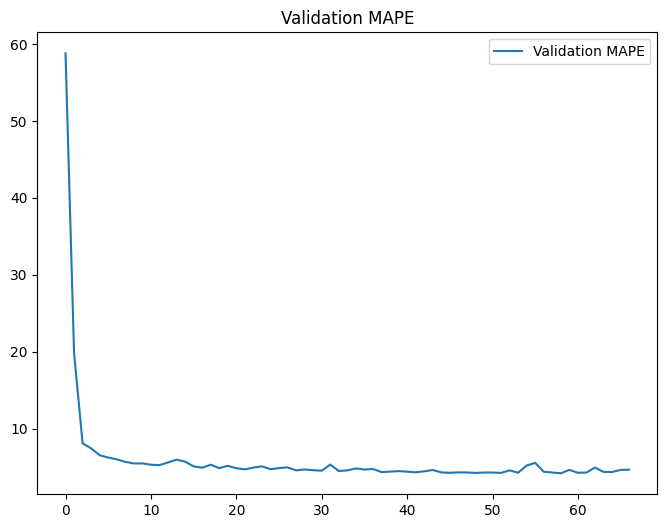

In [27]:
model_fnn_w30h7_preds_inv, model_fnn_w30h7_res = fit_eval(model_fnn, horizon=7, window=30)
model_fnn_w30h7_res

#### FNN - Window Size 90, Horizon 1

Restoring model weights from the end of the best epoch: 60.
Epoch 68: early stopping

--------------------
Evaluating model on test data...
[0.01207301951944828, 0.01207301951944828, 0.0003381227143108845, 2.9965789318084717]
22/22 [==============================] - 0s 656us/step


{'mae': 880.1883, 'mse': 1797189.1, 'rmse': 880.1883, 'mape': 2.975634}

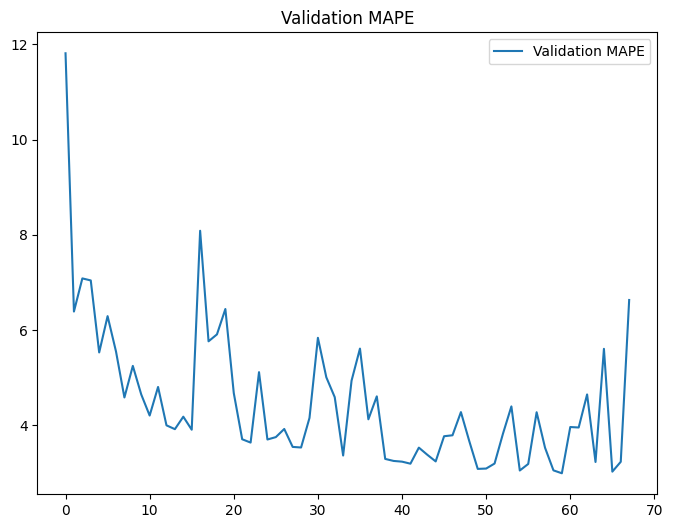

In [28]:
model_fnn_w90h1_preds_inv, model_fnn_w90h1_res = fit_eval(model_fnn, horizon=1, window=90)
model_fnn_w90h1_res

#### FNN - Window Size 90, Horizon 7

Restoring model weights from the end of the best epoch: 61.
Epoch 69: early stopping

--------------------
Evaluating model on test data...
[0.020701108500361443, 0.020701108500361443, 0.0009041280136443675, 5.052801609039307]
22/22 [==============================] - 0s 690us/step


{'mae': 1509.2223, 'mse': 4805618.5, 'rmse': 1509.2223, 'mape': 5.0180445}

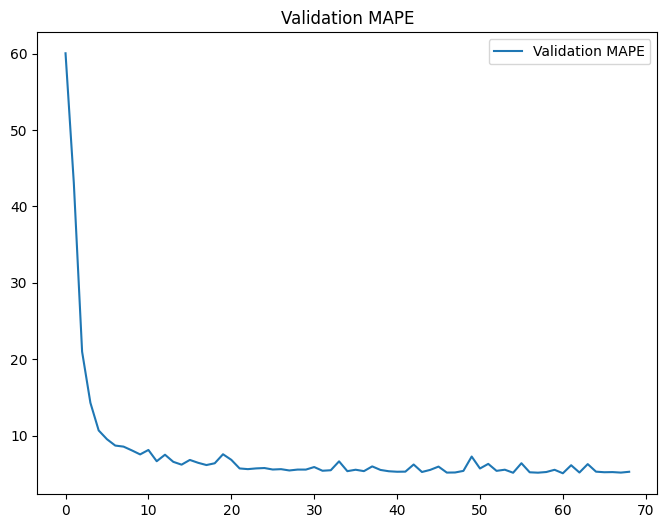

In [29]:
model_fnn_w90h7_preds_inv, model_fnn_w90h7_res = fit_eval(model_fnn, horizon=7, window=90)
model_fnn_w90h7_res

#### FNN - Window Size 90, Horizon 30

Restoring model weights from the end of the best epoch: 22.
Epoch 30: early stopping

--------------------
Evaluating model on test data...
[0.04176368564367294, 0.04176368564367294, 0.0043525174260139465, 9.725522994995117]
22/22 [==============================] - 0s 955us/step


{'mae': 3044.798, 'mse': 23134488.0, 'rmse': 3044.798, 'mape': 9.660841}

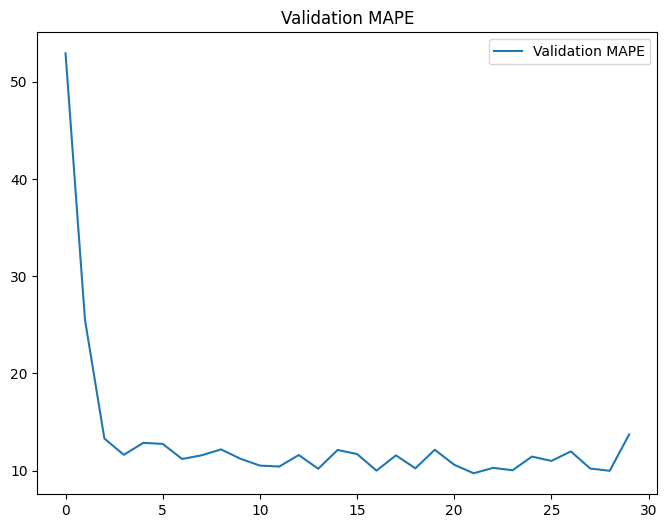

In [30]:
model_fnn_w90h30_preds_inv, model_fnn_w90h30_res = fit_eval(model_fnn, horizon=30, window=90)
model_fnn_w90h30_res

In [31]:
# Compile all results together
model_fnn_res = {
    "W7H1": model_fnn_w7h1_res,
    "W7H7": model_fnn_w7h7_res,
    "W30H1": model_fnn_w30h1_res,
    "W30H7": model_fnn_w30h7_res,
    "W90H1": model_fnn_w90h1_res,
    "W90H7": model_fnn_w90h7_res,
    "W90H30": model_fnn_w90h30_res,
}

In [108]:
all_res["FNN"] = model_fnn_res

### Conv1D (Convolutional Neural Network)

In [32]:
model_conv1d = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
    tf.keras.layers.Conv1D(64, kernel_size=7),
    tf.keras.layers.GlobalMaxPool1D(),
], name="Conv1D")

In [33]:
model_conv1d.build(input_shape=(None, 7))
model_conv1d.summary()

Model: "Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 7, 1)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 64)             512       
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
Total params: 512 (2.00 KB)
Trainable params: 512 (2.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Restoring model weights from the end of the best epoch: 69.
Epoch 77: early stopping

--------------------
Evaluating model on test data...
[0.008022380992770195, 0.008022380992770195, 0.00017818945343606174, 1.8708417415618896]
22/22 [==============================] - 0s 849us/step


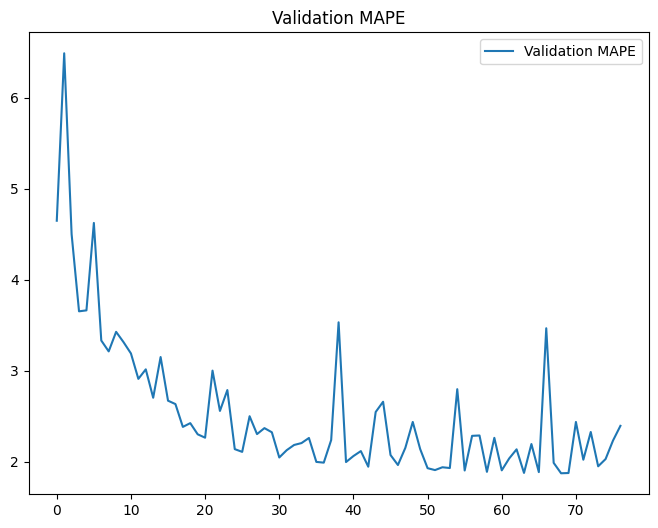

In [34]:
model_conv1d_w7h1_preds_inv, model_conv1d_w7h1_res = fit_eval(model_conv1d, window=7, horizon=1)

### GRU (Gated Recurrent Unit)

In [35]:
model_gru = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    tf.keras.layers.GRU(16, activation="relu")
], name="GRU")


#### GRU - Window Size 7, Horizon 1

Restoring model weights from the end of the best epoch: 8.
Epoch 16: early stopping

--------------------
Evaluating model on test data...
[0.019016679376363754, 0.019016679376363754, 0.0006943387561477721, 4.743015766143799]
22/22 [==============================] - 0s 1ms/step


{'mae': 1386.4187, 'mse': 3690546.8, 'rmse': 1386.4187, 'mape': 4.7098293}

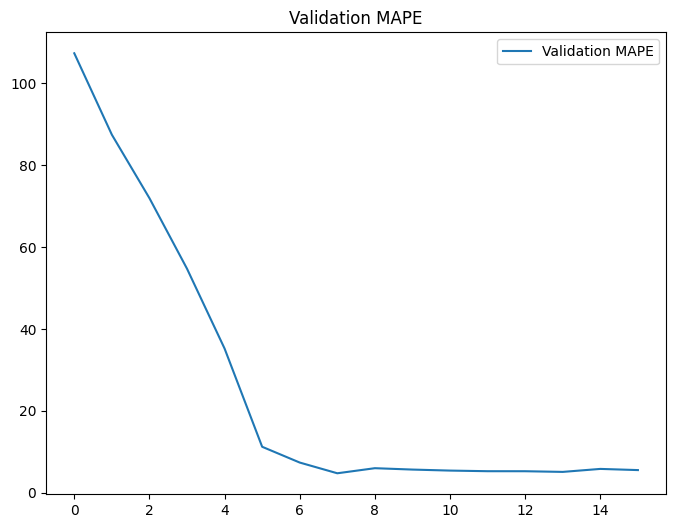

In [36]:
model_gru_w7h1_preds_inv, model_gru_w7h1_res = fit_eval(model_gru, horizon=1, window=7)
model_gru_w7h1_res

#### GRU - Window Size 7, Horizon 7

Restoring model weights from the end of the best epoch: 26.
Epoch 34: early stopping

--------------------
Evaluating model on test data...
[0.023254577070474625, 0.023254577070474625, 0.0011884939158335328, 5.590584754943848]
22/22 [==============================] - 0s 1ms/step


{'mae': 1695.3843, 'mse': 6317079.5, 'rmse': 1695.3843, 'mape': 5.5525966}

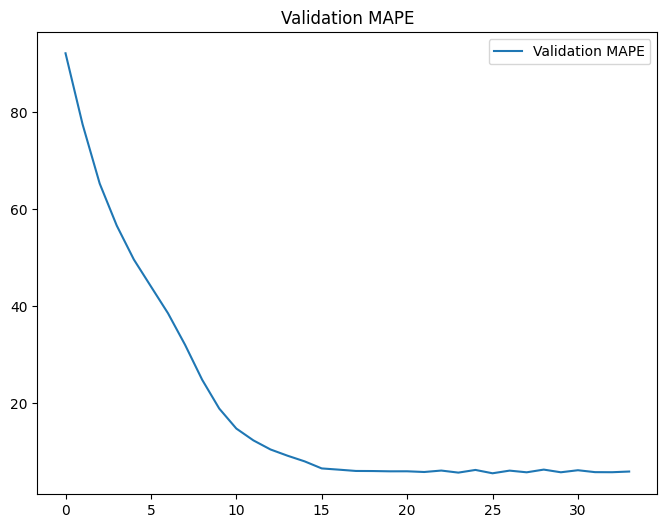

In [37]:
model_gru_w7h7_preds_inv, model_gru_w7h7_res = fit_eval(model_gru, horizon=7, window=7)
model_gru_w7h7_res

#### GRU - Window Size 30, Horizon 1


--------------------
Evaluating model on test data...
[0.009451431222259998, 0.009451431222259998, 0.00021771827596239746, 2.2390365600585938]
22/22 [==============================] - 0s 1ms/step


{'mae': 689.06036, 'mse': 1157215.6, 'rmse': 689.06036, 'mape': 2.2239254}

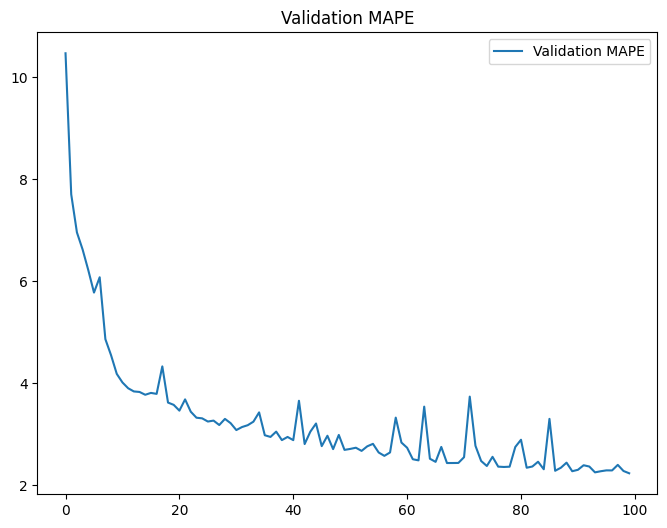

In [38]:
model_gru_w30h1_preds_inv, model_gru_w30h1_res = fit_eval(model_gru, horizon=1, window=30)
model_gru_w30h1_res

#### GRU - Window Size 30, Horizon 7

Restoring model weights from the end of the best epoch: 91.
Epoch 99: early stopping

--------------------
Evaluating model on test data...
[0.017644120380282402, 0.017644120380282402, 0.0007876919698901474, 4.205759048461914]
22/22 [==============================] - 0s 1ms/step


{'mae': 1286.3516, 'mse': 4186738.5, 'rmse': 1286.3516, 'mape': 4.1772566}

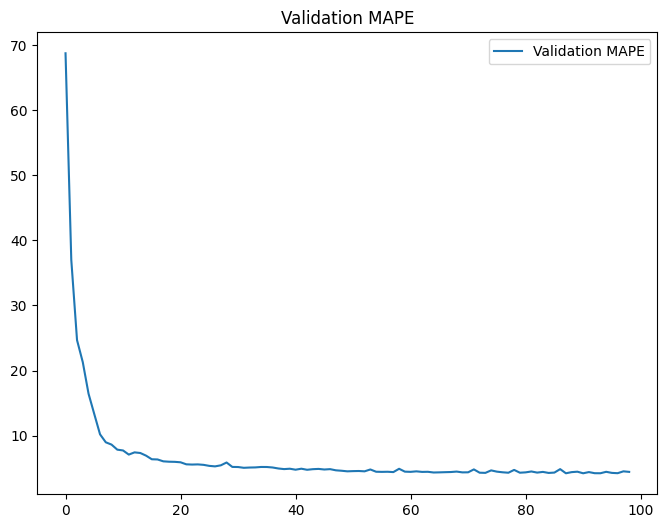

In [39]:
model_gru_w30h7_preds_inv, model_gru_w30h7_res = fit_eval(model_gru, horizon=7, window=30)
model_gru_w30h7_res

#### GRU - Window Size 90, Horizon 1


--------------------
Evaluating model on test data...
[0.013534221798181534, 0.013534221798181534, 0.0003965898940805346, 3.2351043224334717]
22/22 [==============================] - 0s 1ms/step


{'mae': 986.7179, 'mse': 2107953.8, 'rmse': 986.7179, 'mape': 3.2132344}

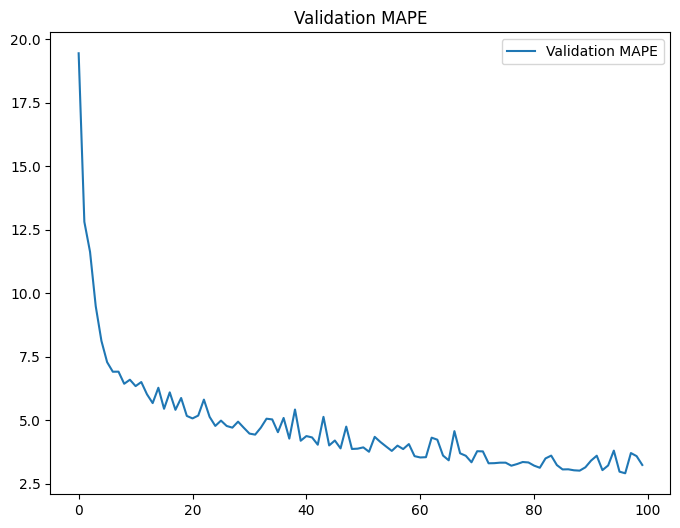

In [40]:
model_gru_w90h1_preds_inv, model_gru_w90h1_res = fit_eval(model_gru, horizon=1, window=90)
model_gru_w90h1_res

#### GRU - Window Size 90, Horizon 7


--------------------
Evaluating model on test data...
[0.019857874140143394, 0.019857874140143394, 0.0009507854119874537, 4.728414058685303]
22/22 [==============================] - 0s 1ms/step


{'mae': 1447.7462, 'mse': 5053612.0, 'rmse': 1447.7462, 'mape': 4.6963286}

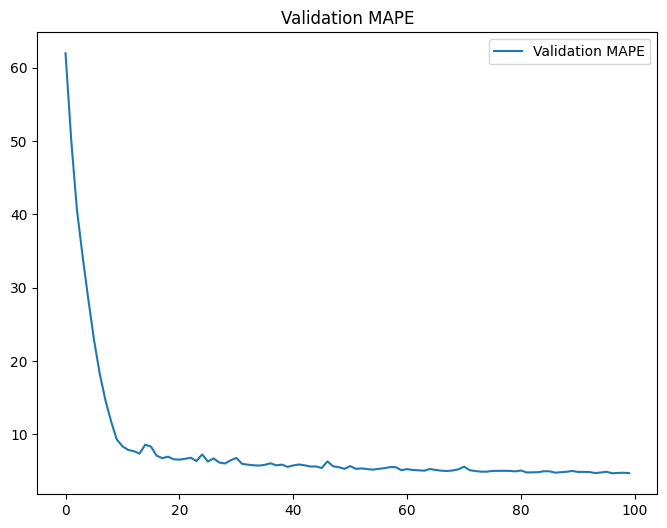

In [41]:
model_gru_w90h7_preds_inv, model_gru_w90h7_res = fit_eval(model_gru, horizon=7, window=90)
model_gru_w90h7_res

#### GRU - Window Size 90, Horizon 30

Restoring model weights from the end of the best epoch: 51.
Epoch 59: early stopping

--------------------
Evaluating model on test data...
[0.03979915753006935, 0.03979915753006935, 0.003773527219891548, 9.663252830505371]
22/22 [==============================] - 0s 1ms/step


{'mae': 2901.5737, 'mse': 20057038.0, 'rmse': 2901.5737, 'mape': 9.596053}

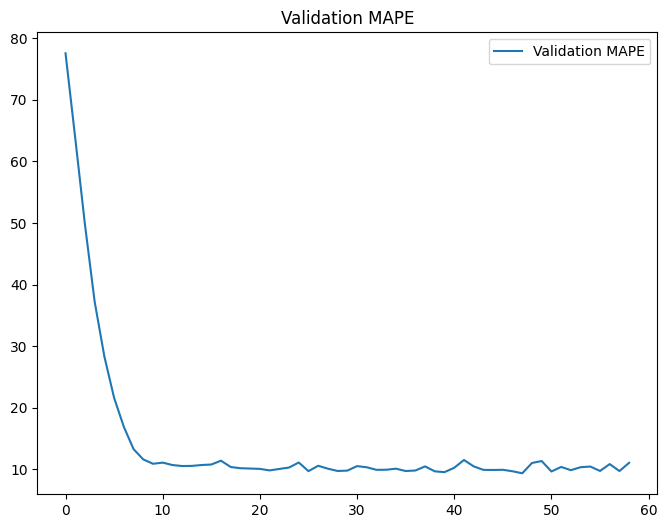

In [42]:
model_gru_w90h30_preds_inv, model_gru_w90h30_res = fit_eval(model_gru, horizon=30, window=90)
model_gru_w90h30_res

In [43]:
# Compile all results together
model_gru_res = {
    "W7H1": model_gru_w7h1_res,
    "W7H7": model_gru_w7h7_res,
    "W30H1": model_gru_w30h1_res,
    "W30H7": model_gru_w30h7_res,
    "W90H1": model_gru_w90h1_res,
    "W90H7": model_gru_w90h7_res,
    "W90H30": model_gru_w90h30_res,
}

In [ ]:
all_res["GRU"] = model_gru_res

### Bidirectional GRU (Gated Recurrent Unit)

In [44]:
model_bi_gru = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(16, activation="relu"))
], name="BiGRU")


#### BiGRU - Window Size 7, Horizon 1

Restoring model weights from the end of the best epoch: 43.
Epoch 51: early stopping

--------------------
Evaluating model on test data...
[0.009157499298453331, 0.009157499298453331, 0.00021554832346737385, 2.1662755012512207]
22/22 [==============================] - 0s 1ms/step


{'mae': 667.6312, 'mse': 1145681.8, 'rmse': 667.6312, 'mape': 2.1516967}

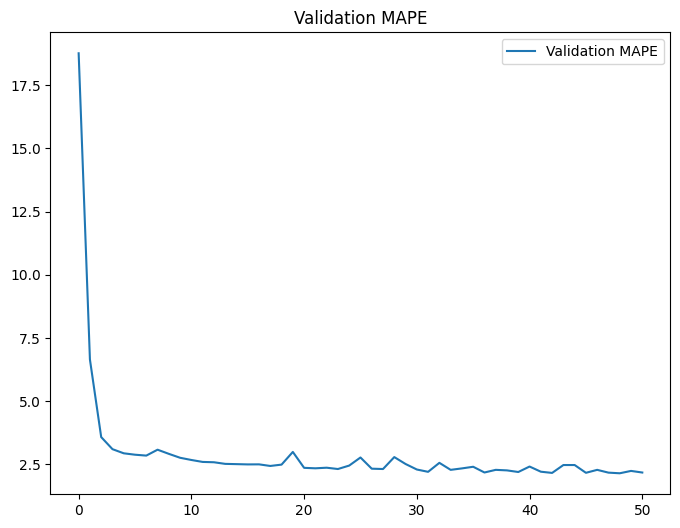

In [45]:
model_bi_gru_w7h1_preds_inv, model_bi_gru_w7h1_res = fit_eval(model_bi_gru, horizon=1, window=7)
model_bi_gru_w7h1_res 

#### BiGRU - Window Size 7, Horizon 7


--------------------
Evaluating model on test data...
[0.017913803458213806, 0.017913803458213806, 0.0007580502424389124, 4.376405239105225]
22/22 [==============================] - 0s 1ms/step


{'mae': 1306.0128, 'mse': 4029186.5, 'rmse': 1306.0128, 'mape': 4.346182}

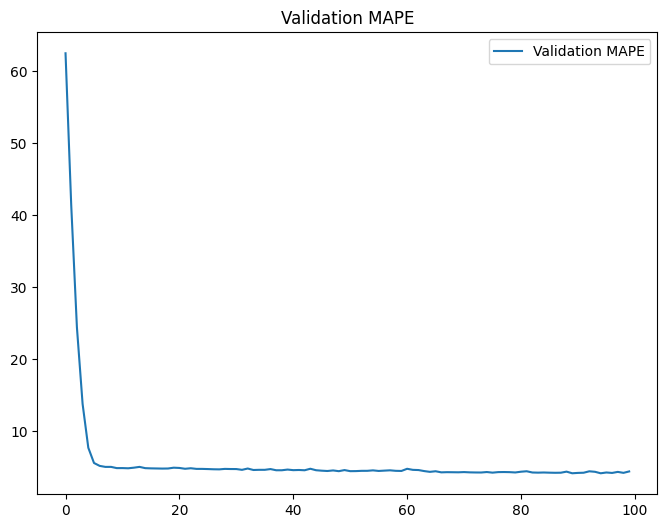

In [46]:
model_bi_gru_w7h7_preds_inv, model_bi_gru_w7h7_res = fit_eval(model_bi_gru, horizon=7, window=7)
model_bi_gru_w7h7_res

#### BiGRU - Window Size 30, Horizon 1

Restoring model weights from the end of the best epoch: 67.
Epoch 75: early stopping

--------------------
Evaluating model on test data...
[0.010884832590818405, 0.010884832590818405, 0.0002840500383172184, 2.5765438079833984]
22/22 [==============================] - 0s 1ms/step


{'mae': 793.56305, 'mse': 1509782.1, 'rmse': 793.56305, 'mape': 2.5591998}

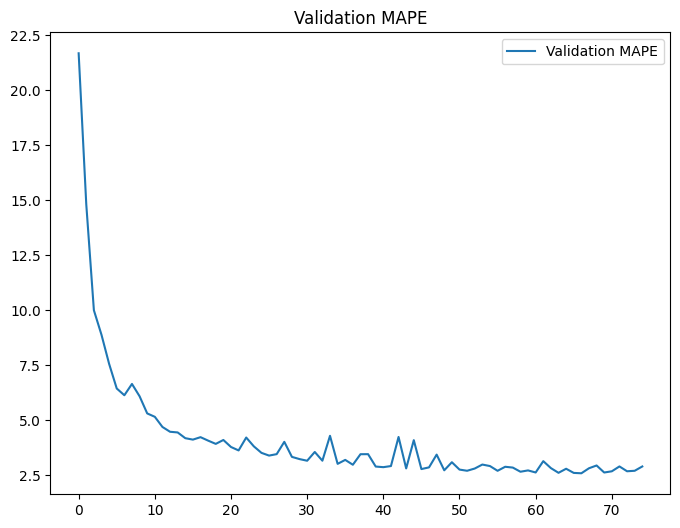

In [47]:
model_bi_gru_w30h1_preds_inv, model_bi_gru_w30h1_res = fit_eval(model_bi_gru, horizon=1, window=30)
model_bi_gru_w30h1_res

#### BiGRU - Window Size 30, Horizon 7

Restoring model weights from the end of the best epoch: 66.
Epoch 74: early stopping

--------------------
Evaluating model on test data...
[0.019338591024279594, 0.019338591024279594, 0.0009205624810419977, 4.618010520935059]
22/22 [==============================] - 0s 1ms/step


{'mae': 1409.8875, 'mse': 4892971.5, 'rmse': 1409.8875, 'mape': 4.5866494}

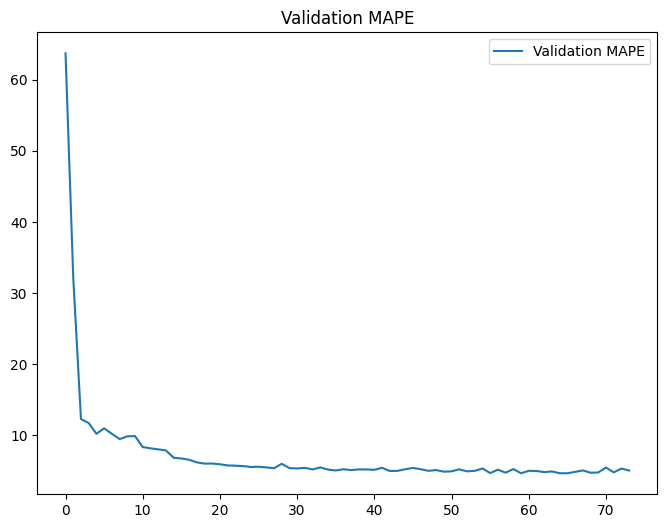

In [48]:
model_bi_gru_w30h7_preds_inv, model_bi_gru_w30h7_res = fit_eval(model_bi_gru, horizon=7, window=30)
model_bi_gru_w30h7_res

#### BiGRU - Window Size 90, Horizon 1

Restoring model weights from the end of the best epoch: 57.
Epoch 65: early stopping

--------------------
Evaluating model on test data...
[0.011699389666318893, 0.011699389666318893, 0.0003038357535842806, 2.825268030166626]
22/22 [==============================] - 0s 1ms/step


{'mae': 852.9485, 'mse': 1614947.0, 'rmse': 852.9485, 'mape': 2.8059042}

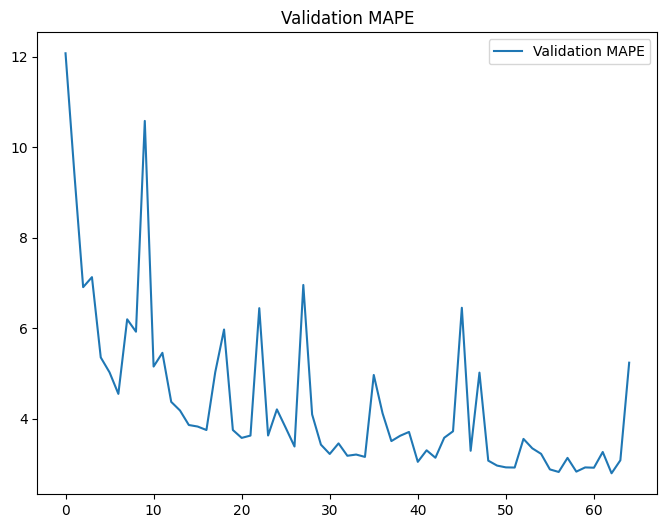

In [49]:
model_bi_gru_w90h1_preds_inv, model_bi_gru_w90h1_res = fit_eval(model_bi_gru, horizon=1, window=90)
model_bi_gru_w90h1_res

#### BiGRU - Window Size 90, Horizon 7

Restoring model weights from the end of the best epoch: 63.
Epoch 71: early stopping

--------------------
Evaluating model on test data...
[0.019766438752412796, 0.019766438752412796, 0.0009797130478546023, 4.702179431915283]
22/22 [==============================] - 0s 1ms/step


{'mae': 1441.08, 'mse': 5207367.5, 'rmse': 1441.08, 'mape': 4.670177}

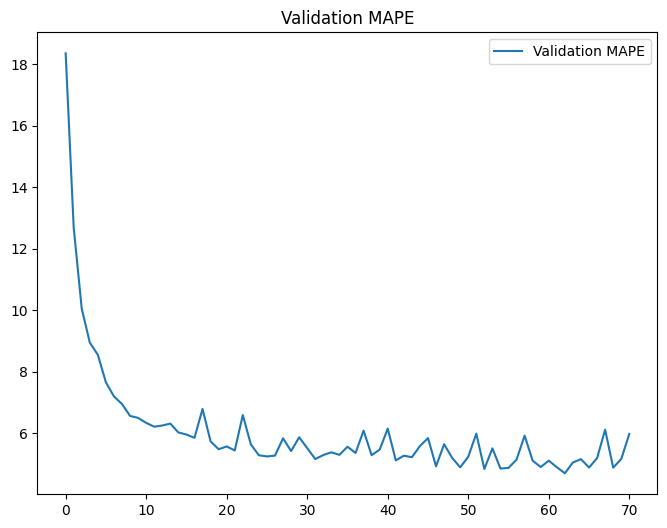

In [50]:
model_bi_gru_w90h7_preds_inv, model_bi_gru_w90h7_res = fit_eval(model_bi_gru, horizon=7, window=90)
model_bi_gru_w90h7_res

#### BiGRU - Window Size 90, Horizon 30


Restoring model weights from the end of the best epoch: 50.
Epoch 58: early stopping

--------------------
Evaluating model on test data...
[0.03796084597706795, 0.03796084597706795, 0.003454955294728279, 9.269637107849121]
22/22 [==============================] - 0s 1ms/step


{'mae': 2767.5505, 'mse': 18363768.0, 'rmse': 2767.5505, 'mape': 9.20497}

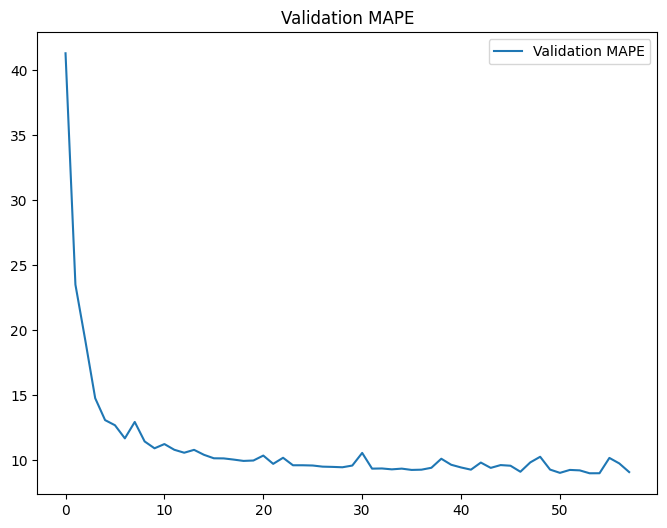

In [51]:
model_bi_gru_w90h30_preds_inv, model_bi_gru_w90h30_res = fit_eval(model_bi_gru, horizon=30, window=90)
model_bi_gru_w90h30_res

In [52]:
# Compile all results together
model_bi_gru_res = {
    "W7H1": model_bi_gru_w7h1_res,
    "W7H7": model_bi_gru_w7h7_res,
    "W30H1": model_bi_gru_w30h1_res,
    "W30H7": model_bi_gru_w30h7_res,
    "W90H1": model_bi_gru_w90h1_res,
    "W90H7": model_bi_gru_w90h7_res,
    "W90H30": model_bi_gru_w90h30_res,
}

In [109]:
all_res["Bi-GRU"] = model_bi_gru_res

## Evaluating Models

In [96]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(pd.DataFrame.from_dict({(i,j): all_res[i][j] 
                           for i in all_res.keys() 
                           for j in all_res[i].keys()},
                       orient='columns').transpose())

                       mae           mse         rmse      mape
FNN    W7H1     666.684204  1.155930e+06   666.684204  2.139875
       W7H7    1264.168579  4.059515e+06  1264.168579  4.099418
       W30H1    717.160767  1.226930e+06   717.160767  2.363645
       W30H7   1283.555176  4.091580e+06  1283.555176  4.162500
       W90H1    880.188293  1.797189e+06   880.188293  2.975634
       W90H7   1509.222290  4.805618e+06  1509.222290  5.018044
       W90H30  3044.798096  2.313449e+07  3044.798096  9.660841
GRU    W7H1    1386.418701  3.690547e+06  1386.418701  4.709829
       W7H7    1695.384277  6.317080e+06  1695.384277  5.552597
       W30H1    689.060364  1.157216e+06   689.060364  2.223925
       W30H7   1286.351562  4.186738e+06  1286.351562  4.177257
       W90H1    986.717896  2.107954e+06   986.717896  3.213234
       W90H7   1447.746216  5.053612e+06  1447.746216  4.696329
       W90H30  2901.573730  2.005704e+07  2901.573730  9.596053
Bi-GRU W7H1     667.631226  1.145682e+06

In [102]:
def plot_grouped(metric = "mape", figsize=(10, 7)):
    """
    Plots a grouped bar chart of the evaluation metrics for each model. Each group represents a different window & horizon combination. Metric must be a valid key in the evaluation results dictionary.
    
    :param metric: str: the evaluation metric to plot, default "mape"
    :param figsize: tuple: the size of the plot, default (10, 7)
    :return: None 
    """
    values = [["W7H1"], ["W7H7"], ["W30H1"], ["W30H7"], ["W90H1"], ["W90H7"], ["W90H30"]]
    for k,v in all_res.items():
        values[0].append(v["W7H1"][metric])
        values[1].append(v["W7H7"][metric])
        values[2].append(v["W30H1"][metric])
        values[3].append(v["W30H7"][metric])
        values[4].append(v["W90H1"][metric])
        values[5].append(v["W90H7"][metric])
        values[6].append(v["W90H30"][metric])
    
    columns=['Windows & Horizons', *all_res.keys()]
    df = pd.DataFrame(values, columns=columns)
    
    df.plot(
        x='Windows & Horizons',
        kind='bar', 
        stacked=False, 
        title=f'{metric.upper()} Values for Different Models and Windows & Horizons',
        figsize=figsize
    )

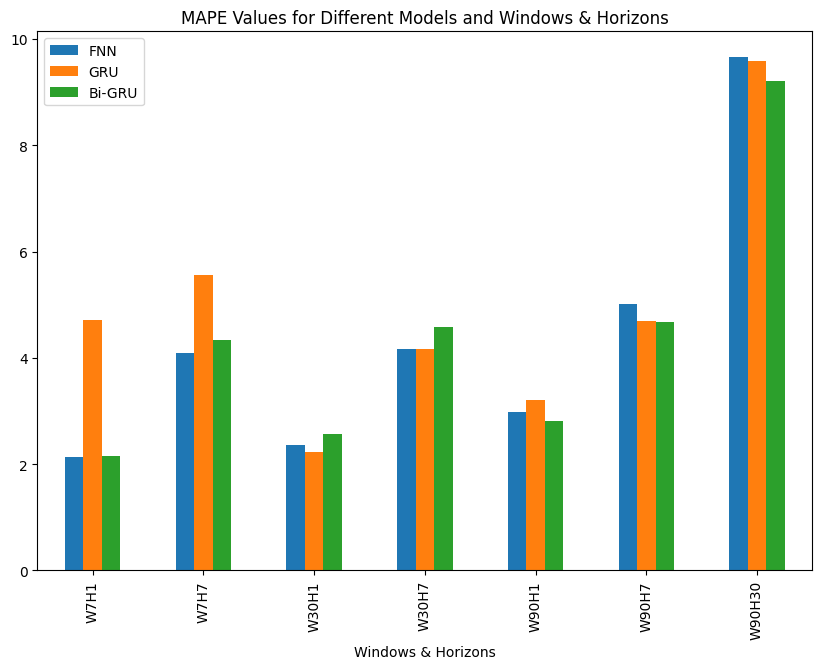

In [100]:
plot_grouped(metric='mape')